# Heading Deviation Over Time Analysis

This notebook analyzes the correlation between time and per-trial deviation of reconstructed heading from true heading.

- Creates separate figures for light and dark trials
- X-axis: Time relative to trial start (absolute and normalized)
- Y-axis: Heading deviation (mvtDirError) in radians
- Y-limits: (-π, π)
- Shows 10 randomly selected trials per condition

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10

In [2]:
# Setup paths
PROJECT_DATA_PATH = 'E:\\GitHub\\Peng_et.al_2025_noInt\\Peng'

# Sessions to use (from setup_project.py)
useAble = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24111022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']

In [3]:
# Load data
print("Loading data...")
fn = os.path.join(PROJECT_DATA_PATH, "results", "reconstuctionDFAutoPI.csv")
dfAutoPI = pd.read_csv(fn)
print(f"Loaded {len(dfAutoPI)} rows")

# Filter for useable sessions
dfAutoPI = dfAutoPI[dfAutoPI.session.isin(useAble)]
print(f"After filtering for useable sessions: {len(dfAutoPI)} rows")
print(f"Sessions: {dfAutoPI.session.nunique()}")
print(f"Conditions: {dfAutoPI.condition.unique()}")

Loading data...
Loaded 6617357 rows
After filtering for useable sessions: 3034796 rows
Sessions: 23
Conditions: ['all_light' 'all_dark' 'searchToLeverPath_light' 'searchToLeverPath_dark'
 'homingFromLeavingLever_light' 'homingFromLeavingLever_dark'
 'homingFromLeavingLeverToPeriphery_light'
 'homingFromLeavingLeverToPeriphery_dark'
 'searchToLeverPathWithBridge_light' 'searchToLeverPathWithBridge_dark'
 'homingFromLeavingLeverWithBridge_light'
 'homingFromLeavingLeverWithBridge_dark' 'atLever_light' 'atLever_dark']


In [4]:
def plot_heading_deviation_by_time(df, condition_name, n_bins=20, output_path=None):
    """
    Plot mean heading deviation over time, separated by positive/negative mean mvt trials.
    
    Parameters:
    -----------
    df : DataFrame
        Filtered dataframe for specific condition
    condition_name : str
        Name of condition for title ('Light' or 'Dark')
    n_bins : int
        Number of time bins (default: 20)
    output_path : str
        Path to save figure (optional)
    """
    # Create unique session-trial identifier
    df['session_trial'] = df['session'] + '_T' + df['trial'].astype(str)
    unique_trials = df['session_trial'].unique()
    
    print(f"\n{condition_name} trials:")
    print(f"Total unique trials: {len(unique_trials)}")
    
    # Separate trials by mean mvt sign
    positive_mvt_trials = []
    negative_mvt_trials = []
    
    for trial_id in unique_trials:
        trial_data = df[df['session_trial'] == trial_id].copy()
        mean_mvt = trial_data['mvtDirError'].mean()
        
        if mean_mvt > 0:
            positive_mvt_trials.append(trial_id)
        elif mean_mvt < 0:
            negative_mvt_trials.append(trial_id)
    
    print(f"Positive mean mvt trials: {len(positive_mvt_trials)}")
    print(f"Negative mean mvt trials: {len(negative_mvt_trials)}")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Function to process and plot trial group
    def process_trial_group(trial_ids, label, color):
        if len(trial_ids) == 0:
            return
        
        # Collect all data with absolute relative time
        all_data = []
        max_time_overall = 0
        
        for trial_id in trial_ids:
            trial_data = df[df['session_trial'] == trial_id].copy()
            
            # Calculate time relative to trial start
            trial_data['time_rel'] = trial_data['recTime'] - trial_data['recTime'].min()
            max_time_overall = max(max_time_overall, trial_data['time_rel'].max())
            
            all_data.append(trial_data[['time_rel', 'mvtDirError']])
        
        if len(all_data) == 0:
            return
        
        # Combine all trials
        combined_data = pd.concat(all_data, ignore_index=True)
        
        # Create bins based on the maximum time across all trials in this group
        bins = np.linspace(0, max_time_overall, n_bins + 1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Bin the data
        combined_data['bin'] = pd.cut(combined_data['time_rel'], bins=bins, 
                                       labels=False, include_lowest=True)
        
        # Calculate mean, SEM, and count for each bin
        bin_stats = combined_data.groupby('bin')['mvtDirError'].agg(['mean', 'sem', 'count']).reset_index()
        bin_stats['bin_center'] = bin_centers[bin_stats['bin'].astype(int)]
        
        print(f"\n{label} - Data points per bin:")
        print(f"  Min count: {bin_stats['count'].min()}")
        print(f"  Max count: {bin_stats['count'].max()}")
        print(f"  Mean count: {bin_stats['count'].mean():.1f}")
        
        # Plot mean with error bars
        ax.plot(bin_stats['bin_center'], bin_stats['mean'], 
                color=color, linewidth=2.5, label=label, alpha=0.9)
        ax.fill_between(bin_stats['bin_center'], 
                        bin_stats['mean'] - bin_stats['sem'],
                        bin_stats['mean'] + bin_stats['sem'],
                        color=color, alpha=0.2)
    
    # Process both groups
    process_trial_group(positive_mvt_trials, 'Positive mean mvt', 'tab:red')
    process_trial_group(negative_mvt_trials, 'Negative mean mvt', 'tab:blue')
    
    # Format plot
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Time from trial start (s)', fontsize=12)
    ax.set_ylabel('Heading deviation (rad)', fontsize=12)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
    ax.set_title(f'Mean Heading Deviation Over Time - {condition_name} Trials', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    
    # Save if path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")
    
    return fig, ax

In [5]:
def plot_heading_deviation_normalized_time(df, condition_name, n_bins=10, output_path=None):
    """
    Plot mean heading deviation over normalized time (0 to 1), separated by positive/negative mean mvt trials.
    Includes duration histogram subplot showing distribution of actual trial durations.

    Parameters:
    -----------
    df : DataFrame
        Filtered dataframe for specific condition
    condition_name : str
        Name of condition for title ('Light' or 'Dark')
    n_bins : int
        Number of normalized time bins (default: 10, each = 10% of trial)
    output_path : str
        Path to save figure (optional)
    """
    # Create unique session-trial identifier
    df['session_trial'] = df['session'] + '_T' + df['trial'].astype(str)
    unique_trials = df['session_trial'].unique()

    print(f"\n{condition_name} trials (normalized time):")
    print(f"Total unique trials: {len(unique_trials)}")

    # Separate trials by mean mvt sign
    positive_mvt_trials = []
    negative_mvt_trials = []

    for trial_id in unique_trials:
        trial_data = df[df['session_trial'] == trial_id].copy()
        mean_mvt = trial_data['mvtDirError'].mean()

        if mean_mvt > 0:
            positive_mvt_trials.append(trial_id)
        elif mean_mvt < 0:
            negative_mvt_trials.append(trial_id)

    print(f"Positive mean mvt trials: {len(positive_mvt_trials)}")
    print(f"Negative mean mvt trials: {len(negative_mvt_trials)}")

    # Create figure with main plot and histogram subplot
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)
    ax_main = fig.add_subplot(gs[0])
    ax_hist = fig.add_subplot(gs[1])

    # Normalized time bins: 0 to 1
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Function to process and plot trial group
    def process_trial_group(trial_ids, label, color):
        if len(trial_ids) == 0:
            return None, []

        # Collect all data with normalized time
        all_data = []
        trial_durations = []

        for trial_id in trial_ids:
            trial_data = df[df['session_trial'] == trial_id].copy()

            # Calculate trial duration
            trial_start = trial_data['recTime'].min()
            trial_duration = trial_data['recTime'].max() - trial_start

            # Skip very short trials
            if trial_duration < 0.5:
                continue

            trial_durations.append(trial_duration)

            # Normalize time to 0-1
            trial_data['time_norm'] = (trial_data['recTime'] - trial_start) / trial_duration

            all_data.append(trial_data[['time_norm', 'mvtDirError']])

        if len(all_data) == 0:
            return None, trial_durations

        # Combine all trials
        combined_data = pd.concat(all_data, ignore_index=True)

        # Bin the data
        combined_data['bin'] = pd.cut(combined_data['time_norm'], bins=bins,
                                       labels=False, include_lowest=True)

        # Calculate mean, SEM, and count for each bin
        bin_stats = combined_data.groupby('bin')['mvtDirError'].agg(['mean', 'sem', 'count']).reset_index()
        bin_stats['bin_center'] = bin_centers[bin_stats['bin'].astype(int)]

        print(f"\n{label} - Data points per bin:")
        print(f"  Min count: {bin_stats['count'].min()}")
        print(f"  Max count: {bin_stats['count'].max()}")
        print(f"  Mean count: {bin_stats['count'].mean():.1f}")

        # Plot mean with error bars on main axis
        ax_main.plot(bin_stats['bin_center'], bin_stats['mean'],
                    color=color, linewidth=2.5, label=label, alpha=0.9)
        ax_main.fill_between(bin_stats['bin_center'],
                            bin_stats['mean'] - bin_stats['sem'],
                            bin_stats['mean'] + bin_stats['sem'],
                            color=color, alpha=0.2)

        return bin_stats, trial_durations

    # Process both groups
    pos_stats, pos_durations = process_trial_group(positive_mvt_trials, 'Positive mean mvt', 'tab:red')
    neg_stats, neg_durations = process_trial_group(negative_mvt_trials, 'Negative mean mvt', 'tab:blue')

    # Format main plot
    ax_main.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
    ax_main.set_xlabel('Normalized time (trial progression)', fontsize=12)
    ax_main.set_ylabel('Heading deviation (rad)', fontsize=12)
    ax_main.set_xlim(0, 1)
    ax_main.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_main.set_ylim(-np.pi, np.pi)
    ax_main.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax_main.set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
    ax_main.set_title(f'Mean Heading Deviation Over Normalized Time - {condition_name} Trials',
                     fontsize=14, fontweight='bold')
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(loc='best', fontsize=10)

    # Plot duration histogram
    all_durations = pos_durations + neg_durations
    if len(all_durations) > 0:
        ax_hist.hist(all_durations, bins=20, color='gray', alpha=0.7, edgecolor='black')

        # Add summary statistics
        median_dur = np.median(all_durations)
        mean_dur = np.mean(all_durations)
        ax_hist.axvline(median_dur, color='red', linestyle='--', linewidth=2, label=f'Median: {median_dur:.1f}s')
        ax_hist.axvline(mean_dur, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_dur:.1f}s')

        ax_hist.set_xlabel('Trial duration (s)', fontsize=10)
        ax_hist.set_ylabel('Count', fontsize=10)
        ax_hist.set_title('Duration Distribution', fontsize=11, fontweight='bold')
        ax_hist.legend(fontsize=8, loc='upper right')
        ax_hist.grid(True, alpha=0.3, axis='y')

        # Print duration statistics
        print(f"\nTrial durations for {condition_name}:")
        print(f"  Min: {np.min(all_durations):.2f}s")
        print(f"  Max: {np.max(all_durations):.2f}s")
        print(f"  Mean: {np.mean(all_durations):.2f}s")
        print(f"  Median: {np.median(all_durations):.2f}s")
        print(f"  Std: {np.std(all_durations):.2f}s")

    plt.tight_layout()

    # Save if path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {output_path}")

    return fig, ax_main

## Absolute Time Analysis (Original)

### Light Trials Analysis


Processing Light Trials
Light trials: 300521 rows, 23 sessions

Light trials:
Total unique trials: 1508
Positive mean mvt trials: 661
Negative mean mvt trials: 847

Positive mean mvt - Data points per bin:
  Min count: 151
  Max count: 94369
  Mean count: 6623.9

Negative mean mvt - Data points per bin:
  Min count: 119
  Max count: 103027
  Mean count: 8326.7
Saved figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\heading_deviation_light_trials.png


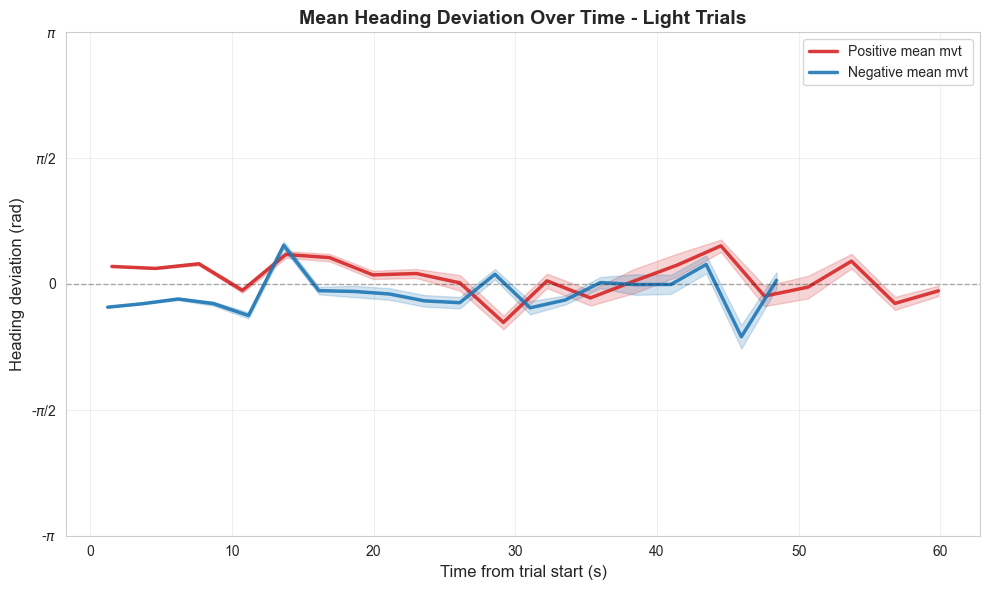

In [6]:
print("\n" + "="*60)
print("Processing Light Trials")
print("="*60)

dfLight = dfAutoPI[dfAutoPI.condition == 'all_light'].copy()
print(f"Light trials: {len(dfLight)} rows, {dfLight.session.nunique()} sessions")

fig_light, ax_light = plot_heading_deviation_by_time(
    dfLight, 
    'Light', 
    output_path=os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_light_trials.png')
)

plt.show()

### Dark Trials Analysis


Processing Dark Trials
Dark trials: 694217 rows, 23 sessions

Dark trials:
Total unique trials: 1396
Positive mean mvt trials: 636
Negative mean mvt trials: 760

Positive mean mvt - Data points per bin:
  Min count: 158
  Max count: 99454
  Mean count: 16028.9

Negative mean mvt - Data points per bin:
  Min count: 323
  Max count: 219439
  Mean count: 18612.2
Saved figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\heading_deviation_dark_trials.png


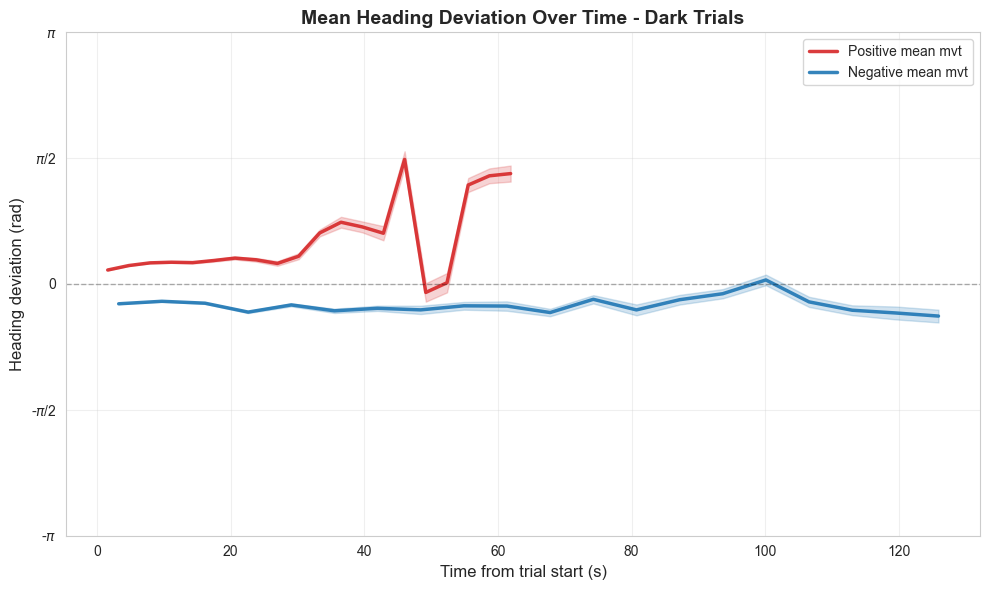

In [7]:
print("\n" + "="*60)
print("Processing Dark Trials")
print("="*60)

dfDark = dfAutoPI[dfAutoPI.condition == 'all_dark'].copy()
print(f"Dark trials: {len(dfDark)} rows, {dfDark.session.nunique()} sessions")

fig_dark, ax_dark = plot_heading_deviation_by_time(
    dfDark, 
    'Dark', 
    output_path=os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_dark_trials.png')
)

plt.show()

## Summary Statistics

In [8]:
# Calculate summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)

for condition, condition_name in [('all_light', 'Light'), ('all_dark', 'Dark')]:
    df_cond = dfAutoPI[dfAutoPI.condition == condition]
    print(f"\n{condition_name} Trials:")
    print(f"  Total data points: {len(df_cond)}")
    print(f"  Unique trials: {df_cond.groupby(['session', 'trial']).ngroups}")
    print(f"  Mean heading deviation: {df_cond['mvtDirError'].mean():.4f} rad")
    print(f"  Std heading deviation: {df_cond['mvtDirError'].std():.4f} rad")
    print(f"  Median absolute deviation: {df_cond['mvtDirError'].abs().median():.4f} rad")


Summary Statistics

Light Trials:
  Total data points: 300521
  Unique trials: 1508
  Mean heading deviation: -0.0561 rad
  Std heading deviation: 1.1736 rad
  Median absolute deviation: 0.5746 rad

Dark Trials:
  Total data points: 694217
  Unique trials: 1396
  Mean heading deviation: -0.0219 rad
  Std heading deviation: 1.3884 rad
  Median absolute deviation: 0.8572 rad


## Combined Comparison Figure (Absolute Time)

Saved combined figure


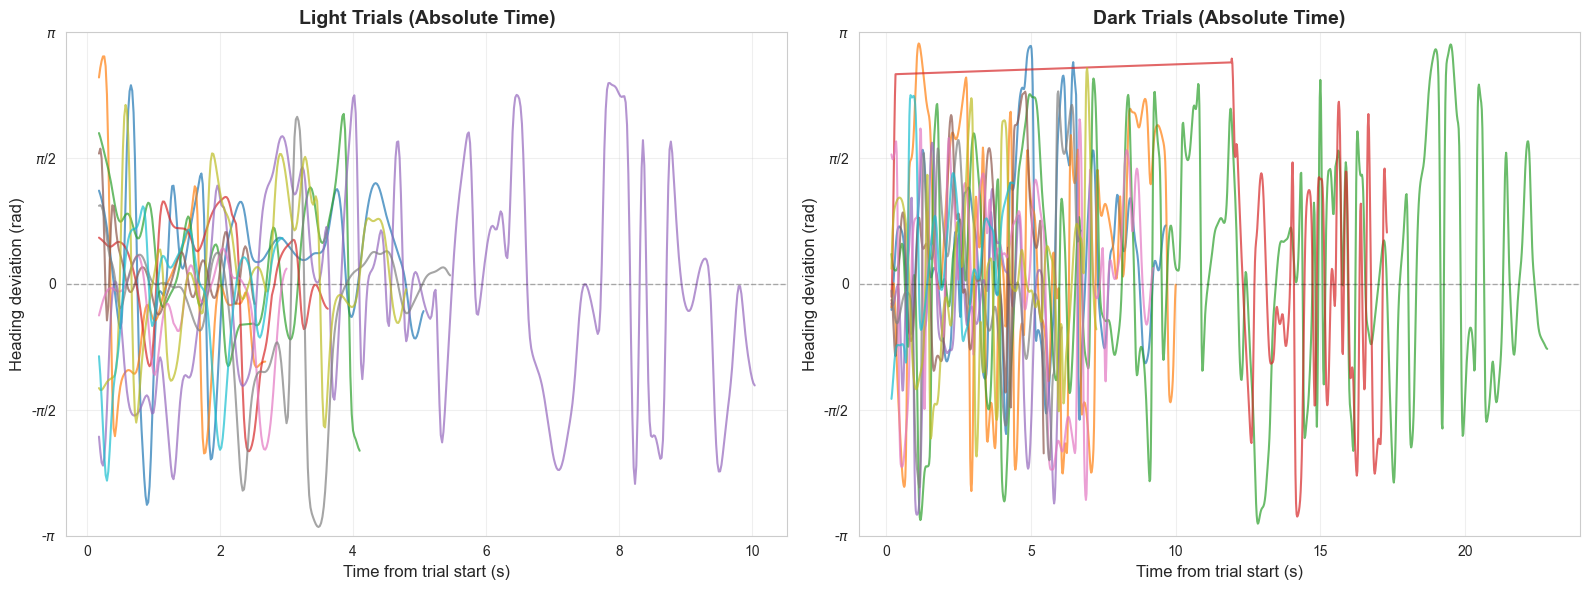

In [9]:
# Create a combined figure with both conditions side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Light trials
dfLight = dfAutoPI[dfAutoPI.condition == 'all_light'].copy()
dfLight['session_trial'] = dfLight['session'] + '_T' + dfLight['trial'].astype(str)
unique_trials_light = dfLight['session_trial'].unique()

np.random.seed(42)
selected_trials_light = np.random.choice(unique_trials_light, min(10, len(unique_trials_light)), replace=False)
colors_light = plt.cm.tab10(np.linspace(0, 1, len(selected_trials_light)))

for i, trial_id in enumerate(selected_trials_light):
    trial_data = dfLight[dfLight['session_trial'] == trial_id].copy()
    trial_data['time_rel'] = trial_data['recTime'] - trial_data['recTime'].min()
    trial_data = trial_data.sort_values('time_rel')
    axes[0].plot(trial_data['time_rel'], scipy.ndimage.gaussian_filter1d(trial_data['mvtDirError'], sigma=2), 
                 color=colors_light[i], alpha=0.7, linewidth=1.5)

axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].set_xlabel('Time from trial start (s)', fontsize=12)
axes[0].set_ylabel('Heading deviation (rad)', fontsize=12)
axes[0].set_ylim(-np.pi, np.pi)
axes[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[0].set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
axes[0].set_title('Light Trials (Absolute Time)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Dark trials
dfDark = dfAutoPI[dfAutoPI.condition == 'all_dark'].copy()
dfDark['session_trial'] = dfDark['session'] + '_T' + dfDark['trial'].astype(str)
unique_trials_dark = dfDark['session_trial'].unique()

np.random.seed(42)
selected_trials_dark = np.random.choice(unique_trials_dark, min(10, len(unique_trials_dark)), replace=False)
colors_dark = plt.cm.tab10(np.linspace(0, 1, len(selected_trials_dark)))

for i, trial_id in enumerate(selected_trials_dark):
    trial_data = dfDark[dfDark['session_trial'] == trial_id].copy()
    trial_data['time_rel'] = trial_data['recTime'] - trial_data['recTime'].min()
    trial_data = trial_data.sort_values('time_rel')
    axes[1].plot(trial_data['time_rel'], scipy.ndimage.gaussian_filter1d(trial_data['mvtDirError'], sigma=2), 
                 color=colors_dark[i], alpha=0.7, linewidth=1.5)

axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].set_xlabel('Time from trial start (s)', fontsize=12)
axes[1].set_ylabel('Heading deviation (rad)', fontsize=12)
axes[1].set_ylim(-np.pi, np.pi)
axes[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[1].set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
axes[1].set_title('Dark Trials (Absolute Time)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_combined.png'), 
            dpi=300, bbox_inches='tight')
print(f"Saved combined figure")
plt.show()

## Normalized Time Analysis

Time-normalized analysis where each trial spans from 0 (start) to 1 (end), regardless of actual duration.
This reveals stereotyped temporal structure of heading errors across trial phases.

### Light Trials (Normalized Time)


Processing Light Trials (Normalized Time)
Light trials: 300521 rows, 23 sessions

Light trials (normalized time):
Total unique trials: 1508
Positive mean mvt trials: 661
Negative mean mvt trials: 847

Positive mean mvt - Data points per bin:
  Min count: 12965
  Max count: 13651
  Mean count: 13247.9

Negative mean mvt - Data points per bin:
  Min count: 16335
  Max count: 17188
  Mean count: 16653.4

Trial durations for Light:
  Min: 1.62s
  Max: 61.40s
  Mean: 4.01s
  Median: 3.42s
  Std: 3.01s


C:\Users\Ikhwan\AppData\Local\Temp\ipykernel_4028\167454034.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\heading_deviation_light_trials_normalized.png


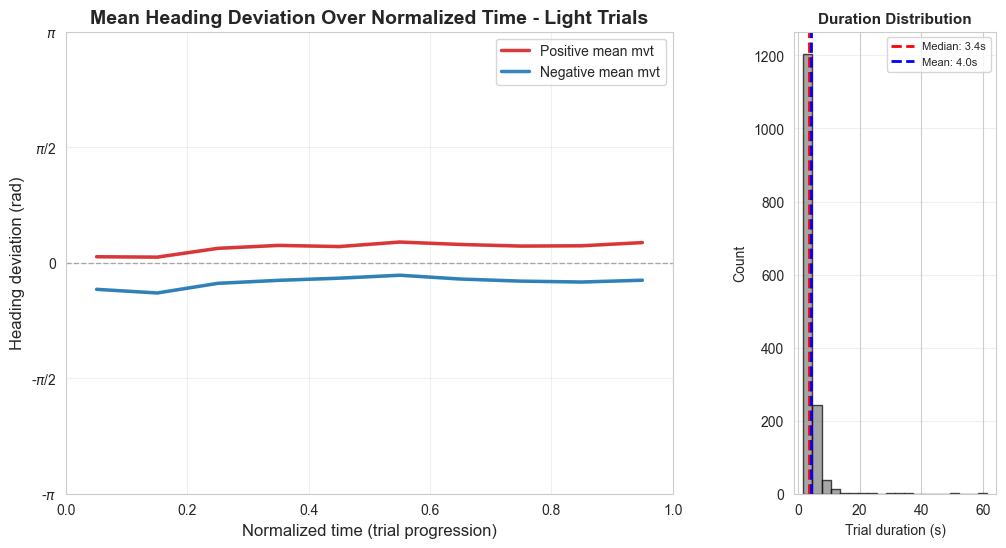

In [10]:
print("\n" + "="*60)
print("Processing Light Trials (Normalized Time)")
print("="*60)

dfLight = dfAutoPI[dfAutoPI.condition == 'all_light'].copy()
print(f"Light trials: {len(dfLight)} rows, {dfLight.session.nunique()} sessions")

fig_light_norm, ax_light_norm = plot_heading_deviation_normalized_time(
    dfLight, 
    'Light', 
    n_bins=10,
    output_path=os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_light_trials_normalized.png')
)

plt.show()

### Dark Trials (Normalized Time)


Processing Dark Trials (Normalized Time)
Dark trials: 694217 rows, 23 sessions

Dark trials (normalized time):
Total unique trials: 1396
Positive mean mvt trials: 636
Negative mean mvt trials: 760

Positive mean mvt - Data points per bin:
  Min count: 31763
  Max count: 32749
  Mean count: 32057.7

Negative mean mvt - Data points per bin:
  Min count: 36818
  Max count: 38178
  Mean count: 37224.4

Trial durations for Dark:
  Min: 1.80s
  Max: 129.16s
  Mean: 10.10s
  Median: 8.44s
  Std: 7.92s


C:\Users\Ikhwan\AppData\Local\Temp\ipykernel_4028\167454034.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\heading_deviation_dark_trials_normalized.png


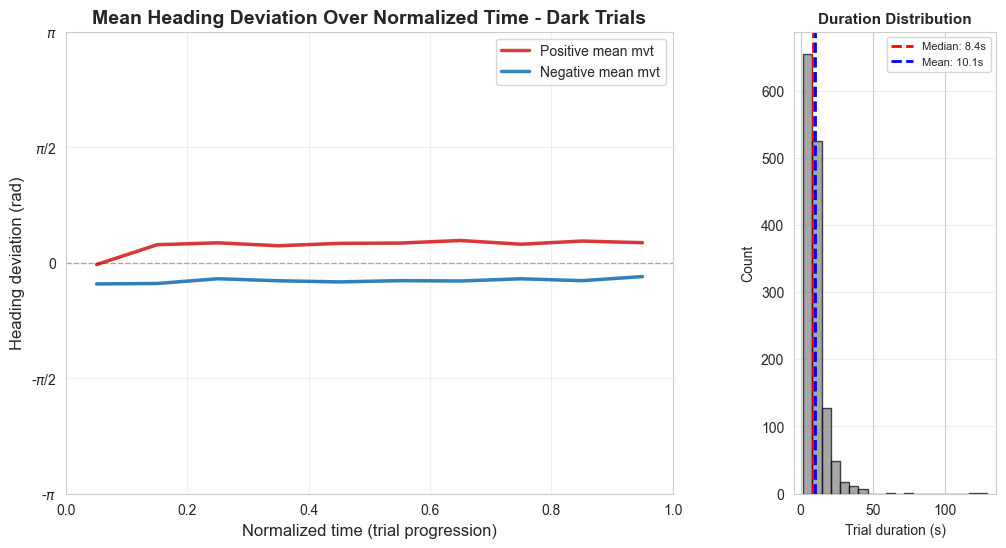

In [11]:
print("\n" + "="*60)
print("Processing Dark Trials (Normalized Time)")
print("="*60)

dfDark = dfAutoPI[dfAutoPI.condition == 'all_dark'].copy()
print(f"Dark trials: {len(dfDark)} rows, {dfDark.session.nunique()} sessions")

fig_dark_norm, ax_dark_norm = plot_heading_deviation_normalized_time(
    dfDark, 
    'Dark', 
    n_bins=10,
    output_path=os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_dark_trials_normalized.png')
)

plt.show()

## Combined Normalized Comparison Figure

Saved normalized combined figure


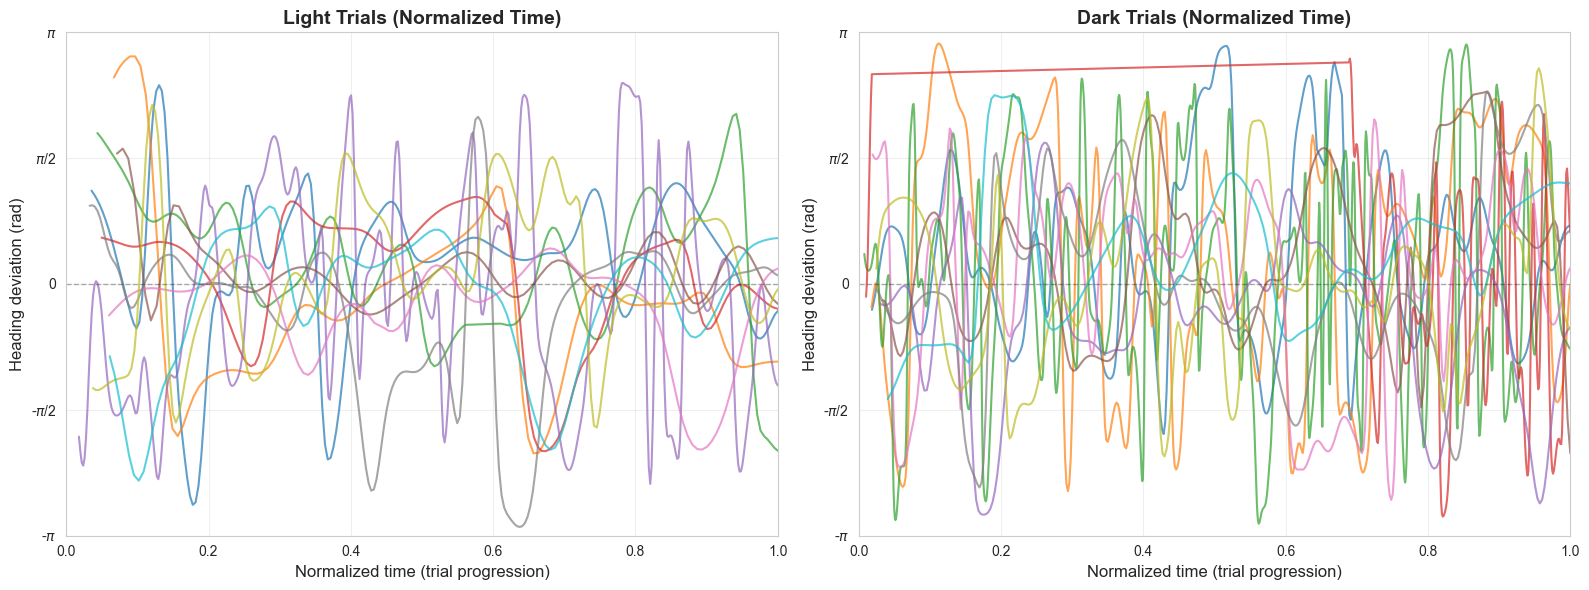

In [12]:
# Create a combined figure with both conditions side by side (normalized time)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Light trials
dfLight = dfAutoPI[dfAutoPI.condition == 'all_light'].copy()
dfLight['session_trial'] = dfLight['session'] + '_T' + dfLight['trial'].astype(str)
unique_trials_light = dfLight['session_trial'].unique()

np.random.seed(42)
selected_trials_light = np.random.choice(unique_trials_light, min(10, len(unique_trials_light)), replace=False)
colors_light = plt.cm.tab10(np.linspace(0, 1, len(selected_trials_light)))

for i, trial_id in enumerate(selected_trials_light):
    trial_data = dfLight[dfLight['session_trial'] == trial_id].copy()
    
    # Normalize time
    trial_start = trial_data['recTime'].min()
    trial_duration = trial_data['recTime'].max() - trial_start
    
    if trial_duration < 0.5:
        continue
    
    trial_data['time_norm'] = (trial_data['recTime'] - trial_start) / trial_duration
    trial_data = trial_data.sort_values('time_norm')
    axes[0].plot(trial_data['time_norm'], scipy.ndimage.gaussian_filter1d(trial_data['mvtDirError'], sigma=2), 
                 color=colors_light[i], alpha=0.7, linewidth=1.5)

axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].set_xlabel('Normalized time (trial progression)', fontsize=12)
axes[0].set_ylabel('Heading deviation (rad)', fontsize=12)
axes[0].set_xlim(0, 1)
axes[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[0].set_ylim(-np.pi, np.pi)
axes[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[0].set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
axes[0].set_title('Light Trials (Normalized Time)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Dark trials
dfDark = dfAutoPI[dfAutoPI.condition == 'all_dark'].copy()
dfDark['session_trial'] = dfDark['session'] + '_T' + dfDark['trial'].astype(str)
unique_trials_dark = dfDark['session_trial'].unique()

np.random.seed(42)
selected_trials_dark = np.random.choice(unique_trials_dark, min(10, len(unique_trials_dark)), replace=False)
colors_dark = plt.cm.tab10(np.linspace(0, 1, len(selected_trials_dark)))

for i, trial_id in enumerate(selected_trials_dark):
    trial_data = dfDark[dfDark['session_trial'] == trial_id].copy()
    
    # Normalize time
    trial_start = trial_data['recTime'].min()
    trial_duration = trial_data['recTime'].max() - trial_start
    
    if trial_duration < 0.5:
        continue
    
    trial_data['time_norm'] = (trial_data['recTime'] - trial_start) / trial_duration
    trial_data = trial_data.sort_values('time_norm')
    axes[1].plot(trial_data['time_norm'], scipy.ndimage.gaussian_filter1d(trial_data['mvtDirError'], sigma=2), 
                 color=colors_dark[i], alpha=0.7, linewidth=1.5)

axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].set_xlabel('Normalized time (trial progression)', fontsize=12)
axes[1].set_ylabel('Heading deviation (rad)', fontsize=12)
axes[1].set_xlim(0, 1)
axes[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[1].set_ylim(-np.pi, np.pi)
axes[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[1].set_yticklabels([r'-$\pi$', r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$'])
axes[1].set_title('Dark Trials (Normalized Time)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DATA_PATH, 'results', 'heading_deviation_combined_normalized.png'), 
            dpi=300, bbox_inches='tight')
print(f"Saved normalized combined figure")
plt.show()